In [1]:
import ot
import torch

import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

from hswfs.manifold.euclidean import Euclidean
from hswfs.manifold.lorentz import Lorentz
from hswfs.manifold.poincare import Poincare
from hswfs.chswf import chswf
from hswfs.utils_swf import utils_plot_poincare

2023-09-26 15:55:10.715557: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-26 15:55:10.798101: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-26 15:55:12.577252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-26 15:55:12.577517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-26 15:55:12.577544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Ca

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                    (0.5, 0.0, 0.1),
                    (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.1, 0.0),
                   (1.0, 0.0, 0.0))
         }

blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1, N=256)

### Utils Plot

In [4]:
def plot_trajectory(particles, colorbar=False, ax=None):
    x0 = particles[0]
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(10,10))

    circle = plt.Circle((0, 0), 1, color='k', linewidth=2, fill=False)
    ax.add_patch(circle)
    ax.axis("equal")

    ts = np.arange(len(particles))
    
    for k in range(x0.shape[0]):
        segments = [np.column_stack([particles[i:i+2,k,0], particles[i:i+2,k,1]]) for i in range(len(particles))]
                
        lc = LineCollection(segments, cmap=blue_red1, array=ts)
        line = ax.add_collection(lc)
    
#     for i in range(len(particles[0])):
#         L0 = []
#         L1 = []
        
#         for k in range(len(particles)):
#             L0.append(particles[k][i,0])
#             L1.append(particles[k][i,1])
                
#         plt.plot(L0, L1, c="gray")
        

    if colorbar:
        cb = fig.colorbar(line, ax=ax)
        
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    ax.scatter(x0[:,0], x0[:,1], label="Initial particles", c="blue")
    ax.scatter(particles[-1][:,0], particles[-1][:,1], label="Final particles", c="red")
    
    ax.set_xlim(-1.01, 1.01)
    ax.set_ylim(-1.01, 1.01)
#     plt.axis("equal")
    ax.axis("off")

### Data

In [5]:
K = -1
d = 2

manifold_lorentz_geod = Lorentz(d=d+1, K=K, projection="geodesic", device=device)
manifold_lorentz_horo = Lorentz(d=d+1, K=K, projection="horospheric", device=device)
manifold_poincare_horo = Poincare(d=d, K=K, projection="horospheric", device=device)
manifold_euclidean = Euclidean(d=d)

In [6]:
n = 10000

# mu = torch.tensor([8, np.sqrt(63), 0], dtype=torch.float64, device=device)
mu = torch.tensor([8, np.sqrt(64 + 1/K), 0], dtype=torch.float64, device=device)
sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)

X_target = manifold_lorentz_geod.sample_wrapped_normal(n, mu, sigma) # sampleWrappedNormal(mu, sigma, n)
X_target_poincare = manifold_lorentz_geod.to_poincare(X_target)
ydata = torch.zeros(n)

train_dataset = torch.utils.data.TensorDataset(X_target, ydata)
rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=500, sampler=rand_sampler)
dataiter_lorentz = iter(cycle(train_sampler))

batch_data0 = next(dataiter_lorentz)[0]


train_dataset_poincare = torch.utils.data.TensorDataset(X_target_poincare, ydata)
rand_sampler_poincare = torch.utils.data.RandomSampler(train_dataset_poincare) #, replacement=True)
train_sampler_poincare = torch.utils.data.DataLoader(train_dataset_poincare, batch_size=500, 
                                                     sampler=rand_sampler_poincare)
dataiter_poincare = iter(cycle(train_sampler_poincare))

### SWF on Poincaré

Let $\mathcal{F}(\mu) = \frac12 SW_2^2(\mu,\nu)$.

For any $k\ge 0$, $i\in\{1,\dots,n\}$, $x_{k+1}^i = x_k^i + \tau \hat{v}_k(x_k^i),$
with $$\hat{v}_k(x) = -\nabla_{W_2}\mathcal{F}(\mu)(x) = - \frac{1}{L} \sum_{\ell=1}^L \psi_{k,\theta_\ell}'(\langle x,\theta_\ell\rangle)\theta_\ell = -\frac{1}{L}\sum_{\ell=1}^L \big(\langle x,\theta_\ell\rangle - F_{P^{\theta_\ell}_\#\nu}^{-1}(F_{P^{\theta_\ell}_\#\mu_k}(\langle x, \theta_\ell\rangle))\big)\theta_\ell$$.

In [7]:
n = 500
d = 2

mu0 = torch.zeros(d, device=device, dtype=torch.float64)
sigma0 = torch.eye(d, dtype=torch.float, device=device)

x0 = manifold_poincare_horo.sample_wrapped_normal(n, mu0, sigma0)

L = chswf(x0, 101, dataiter_poincare, manifold_euclidean, tauk=1, n_projs=100)

  0%|          | 0/101 [00:00<?, ?it/s]

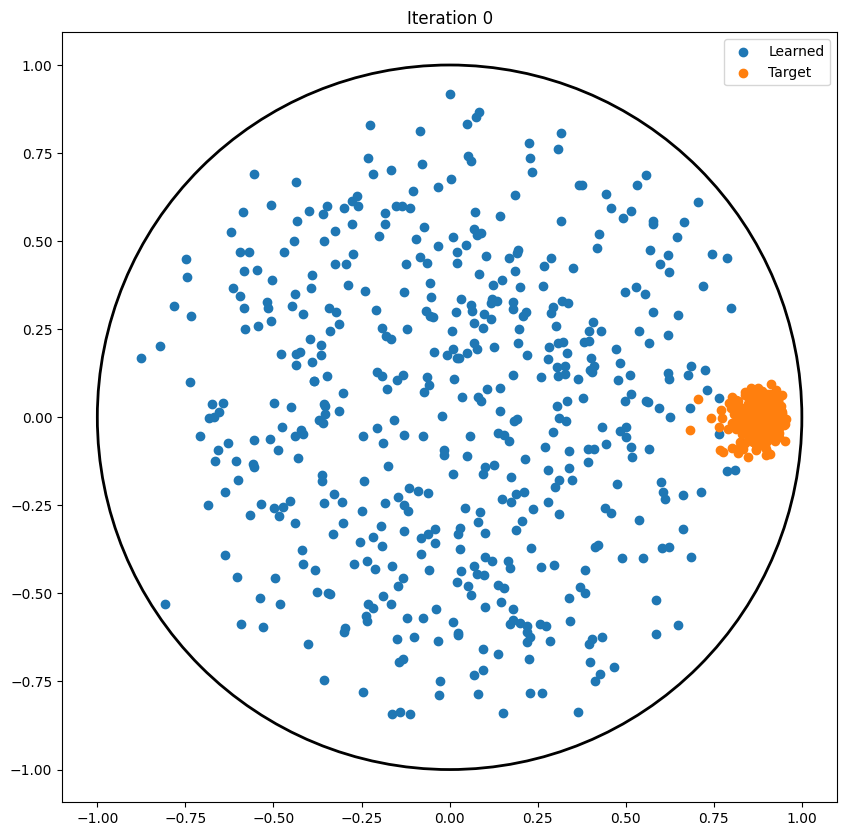

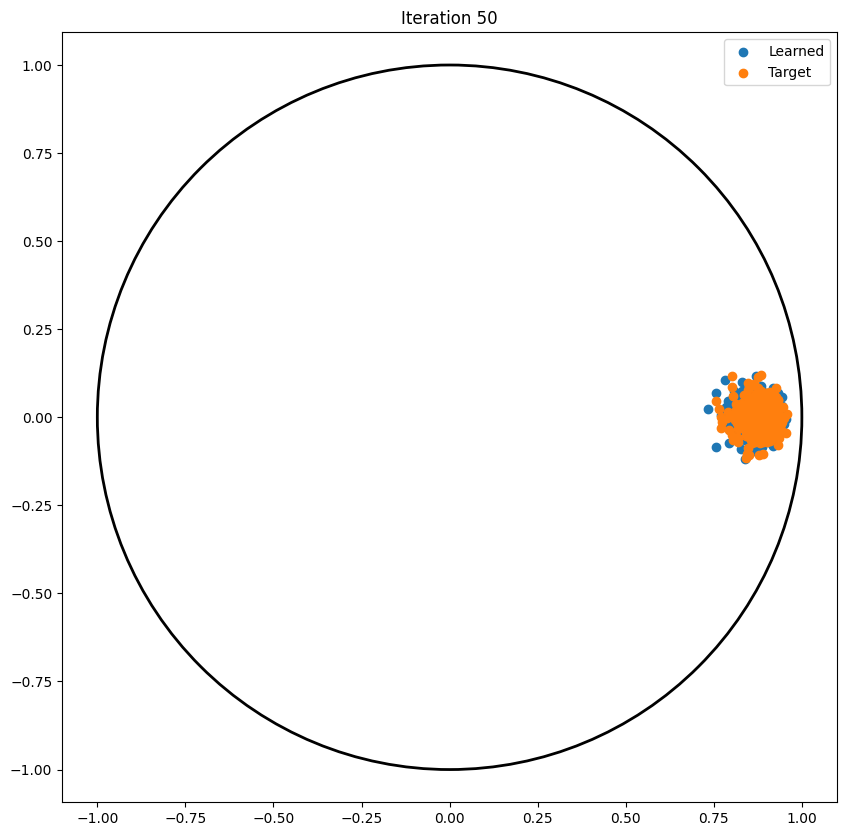

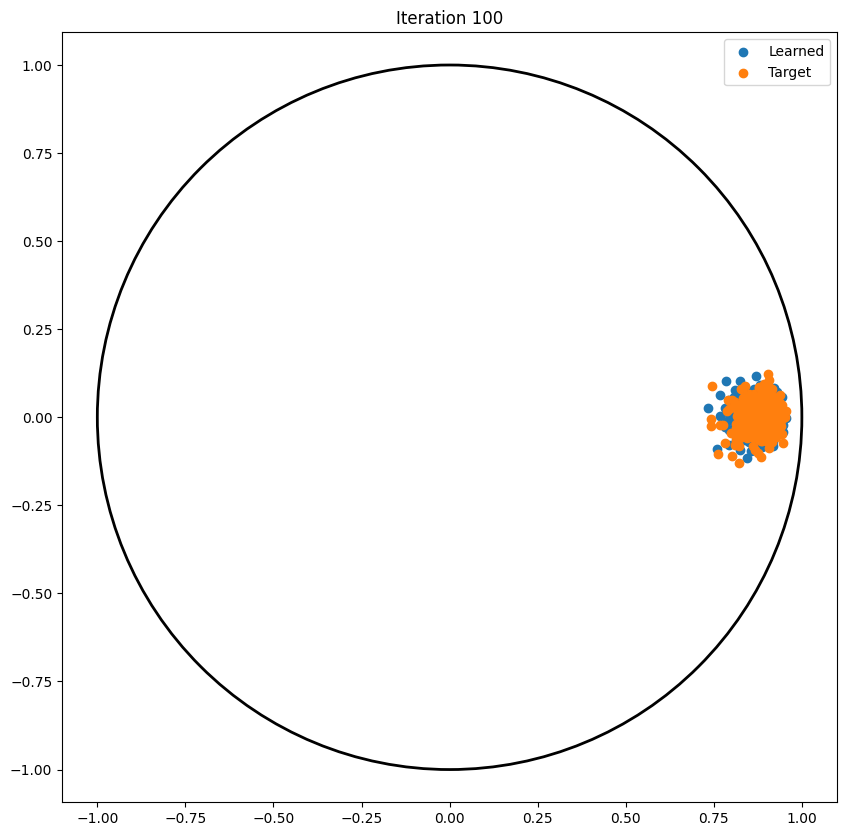

In [8]:
for k in range(0, 101, 50):
    target = next(dataiter_poincare)[0].detach()

    utils_plot_poincare(L[k], target, k)

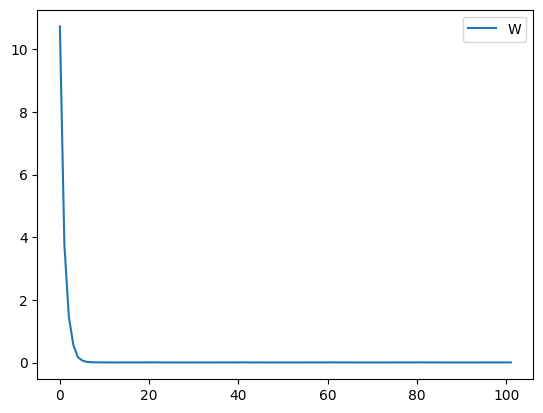

In [9]:
L_w_sw = []

for x in L:
    target = next(dataiter_poincare)[0].detach().to(device)
    
    a = torch.ones((n,), device=device)/n
    b = torch.ones((n,), device=device)/n
    
    x_l = manifold_poincare_horo.to_lorentz(x)
    target_l = manifold_poincare_horo.to_lorentz(target)
    
    M = torch.arccosh(torch.clamp(-manifold_lorentz_horo.minkowski_ip2(x_l, target_l), min=1+1e-15))**2
    w = ot.emd2(a, b, M)
    L_w_sw.append(w.item())


plt.plot(L_w_sw, label="W")
plt.legend()
plt.show()

### HSWF on Lorentz

#### GHSWF

Let $\mathcal{F}(\mu) = \frac12 GHSW_2^2(\mu,\nu)$.

We have $\mathrm{grad}P^v(x) = - \frac{\langle x,x^0\rangle_\mathbb{L} v - \langle x,v\rangle_\mathbb{L} x^0}{\langle x,x^0\rangle_\mathbb{L}^2 - \langle x, v\rangle_\mathbb{L}^2}$.

Thus,
$$ x_{k+1}^i = \exp_{x_k}(\tau \hat{v}_k) = \exp_{x_k}\left(-\tau \frac{1}{L} \sum_{\ell=1}^L \big(P^{v_\ell}(x_k^i) - F_{P^{v_\ell}_\#\mu}^{-1}(F_{P^v_\#\nu}(P^{v_\ell}(x_k^i)))\big) \mathrm{grad} P^{v_\ell}(x_k^i)\right).$$

In [10]:
n = 500

sigma0 = torch.eye(d, dtype=torch.float, device=device)
x0 = manifold_lorentz_geod.sample_wrapped_normal(n, manifold_lorentz_geod.x0, sigma0)

L = chswf(x0, 101, dataiter_lorentz, manifold_lorentz_geod, tauk=1, n_projs=100)

  0%|          | 0/101 [00:00<?, ?it/s]

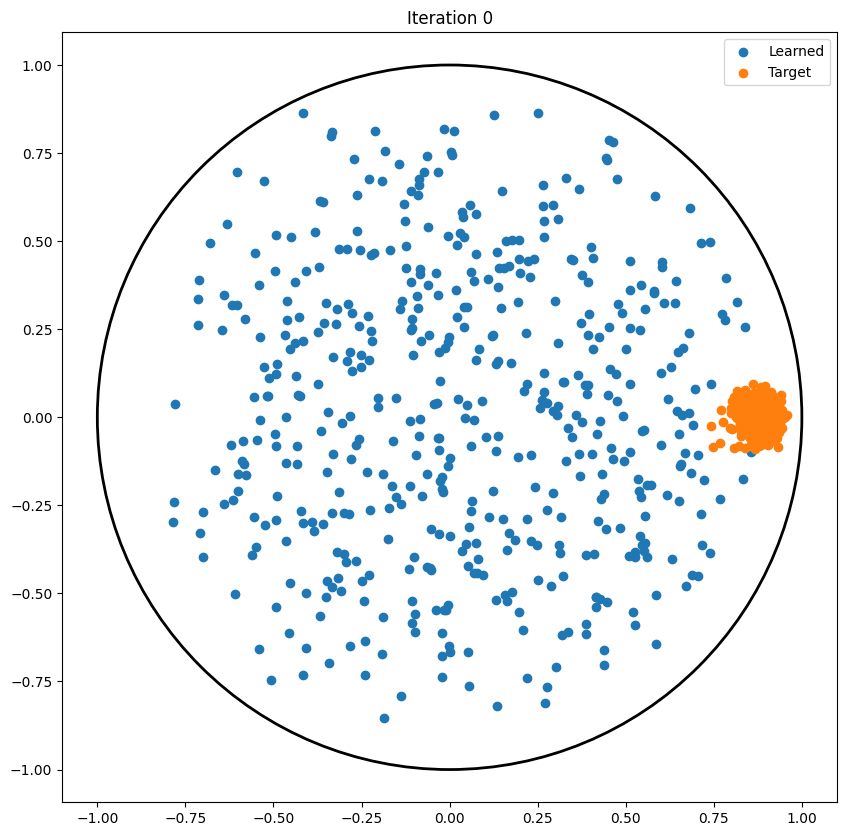

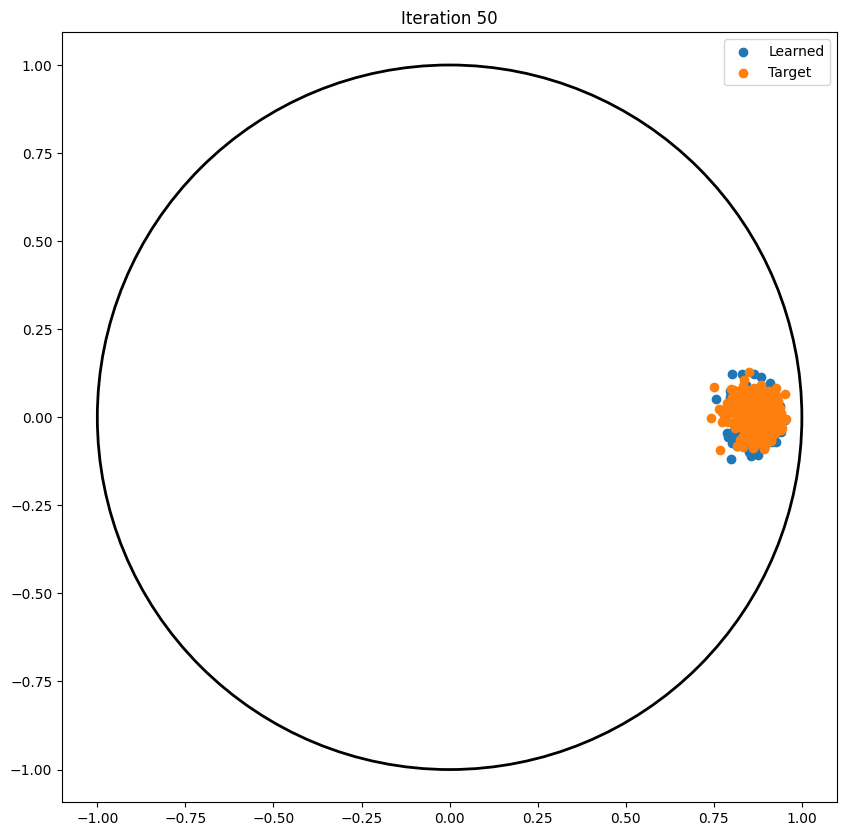

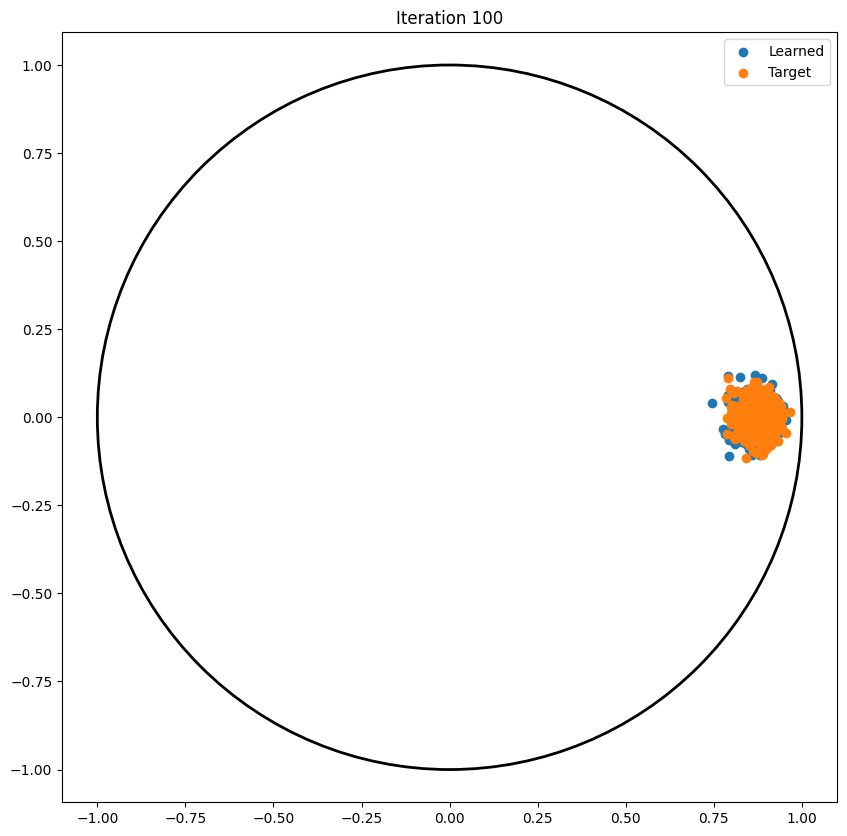

In [11]:
for k in range(0, 101, 50):
    target = next(dataiter_lorentz)[0].detach()
    
    x_p = manifold_lorentz_geod.to_poincare(L[k])
    target_p = manifold_lorentz_geod.to_poincare(target)

    utils_plot_poincare(x_p, target_p, iter=k, K=K)

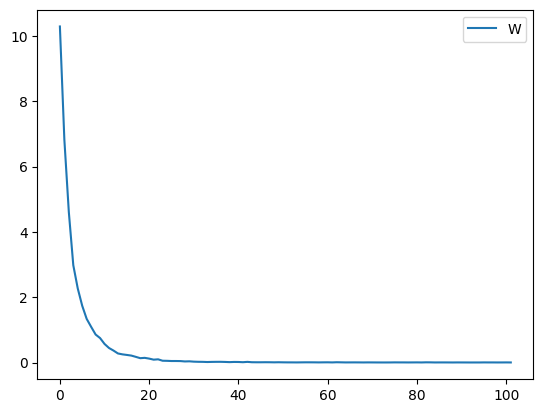

In [12]:
L_w_ghsw = []

for x in L:
    target = next(dataiter_lorentz)[0].detach().to(device)
    
    a = torch.ones((n,), device=device)/n
    b = torch.ones((n,), device=device)/n
    
    M = torch.arccosh(torch.clamp(-manifold_lorentz_horo.minkowski_ip2(x, target), min=1+1e-15))**2
    w = ot.emd2(a, b, M)
    L_w_ghsw.append(w.item())


plt.plot(L_w_ghsw, label="W")
plt.legend()
plt.show()

#### HHSWF

Let $\mathcal{F}(\mu) = \frac12 HHSW_2^2(\mu,\nu)$.

We have $\mathrm{grad}B^v(x) = \frac{1}{\langle x, x^0 + v\rangle_\mathbb{L}}(x^0 + v) + x$.

Thus,
$$ x_{k+1}^i = \exp_{x_k}(\tau \hat{v}_k) = \exp_{x_k}\left(-\tau \frac{1}{L} \sum_{\ell=1}^L \big(B^{v_\ell}(x_k^i) - F_{B^{v_\ell}_\#\mu}^{-1}(F_{B^v_\#\nu}(B^{v_\ell}(x_k^i)))\big) \mathrm{grad} B^{v_\ell}(x_k^i)\right).$$

In [13]:
n = 500
d = 2

mu0 = torch.zeros(d+1, device=device, dtype=torch.float64)
mu0[0] = 1
sigma0 = torch.eye(d, dtype=torch.float, device=device)

x0 = manifold_lorentz_horo.sample_wrapped_normal(n, mu0, sigma0)

L = chswf(x0, 101, dataiter_lorentz, manifold_lorentz_horo, tauk=1)

  0%|          | 0/101 [00:00<?, ?it/s]

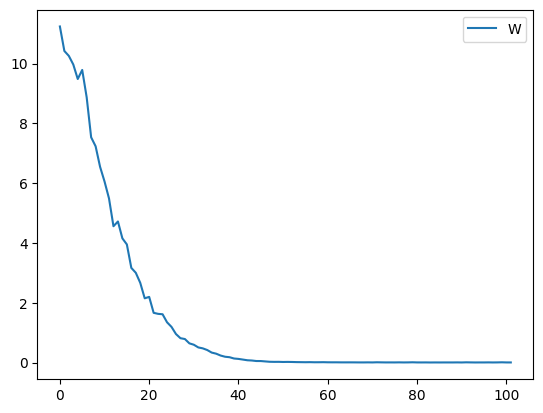

In [14]:
L_w_hhsw = []

for x in L:
    target = next(dataiter_lorentz)[0].detach().to(device)
    
    a = torch.ones((n,), device=device)/n
    b = torch.ones((n,), device=device)/n
    
    M = torch.arccosh(torch.clamp(-manifold_lorentz_geod.minkowski_ip2(x, target), min=1+1e-15))**2
    w = ot.emd2(a, b, M)
    L_w_hhsw.append(w.item())


plt.plot(L_w_hhsw, label="W")
plt.legend()
plt.show()

### HHSWF on Poincaré

In [15]:
n = 500
d = 2

mu0 = manifold_lorentz_horo.to_poincare(manifold_lorentz_horo.x0)
sigma0 = torch.eye(d, dtype=torch.float, device=device)

x0 = manifold_poincare_horo.sample_wrapped_normal(n, mu0, sigma0)

L = chswf(x0, 101, dataiter_poincare, manifold_poincare_horo, tauk=1, n_projs=100)

  0%|          | 0/101 [00:00<?, ?it/s]

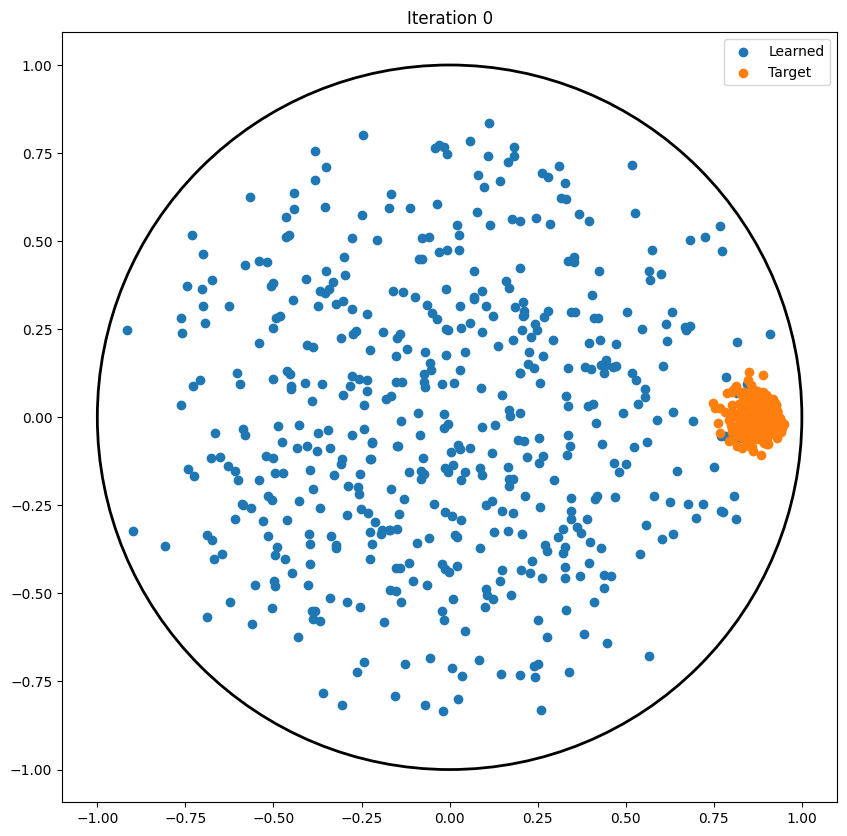

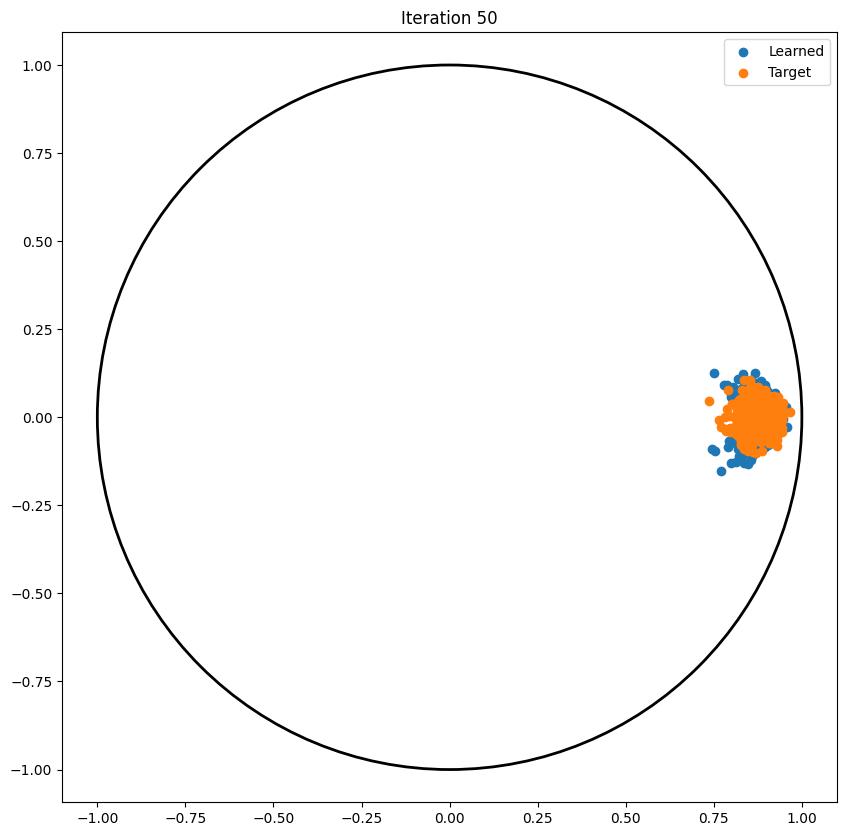

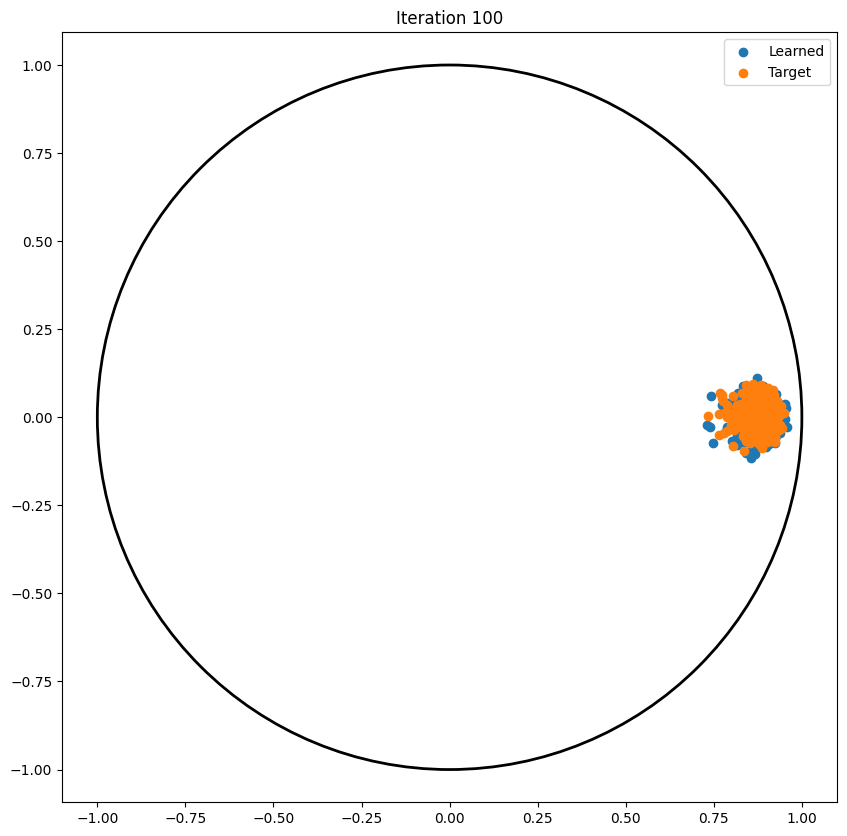

In [16]:
for k in range(0, 101, 50):
    target = next(dataiter_poincare)[0].detach()

    utils_plot_poincare(L[k], target, k, K=K)

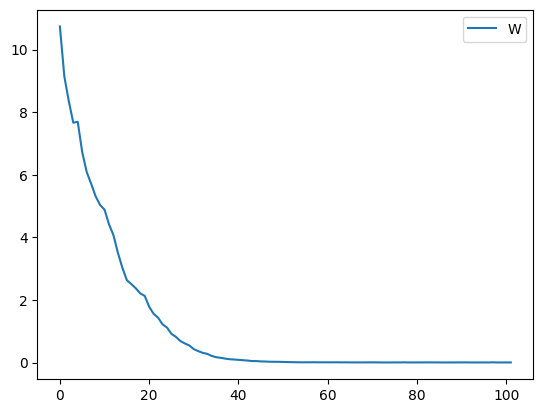

In [17]:
L_w_hhsw_p = []

for x in L:
    target = next(dataiter_poincare)[0].detach().to(device)
    
    a = torch.ones((n,), device=device)/n
    b = torch.ones((n,), device=device)/n
    
    x_l = manifold_poincare_horo.to_lorentz(x)
    target_l = manifold_poincare_horo.to_lorentz(target)
    
    M = torch.arccosh(torch.clamp(-manifold_lorentz_horo.minkowski_ip2(x_l, target_l), min=1+1e-15))**2
    w = ot.emd2(a, b, M)
    L_w_hhsw_p.append(w.item())


plt.plot(L_w_hhsw_p, label="W")
plt.legend()
plt.show()

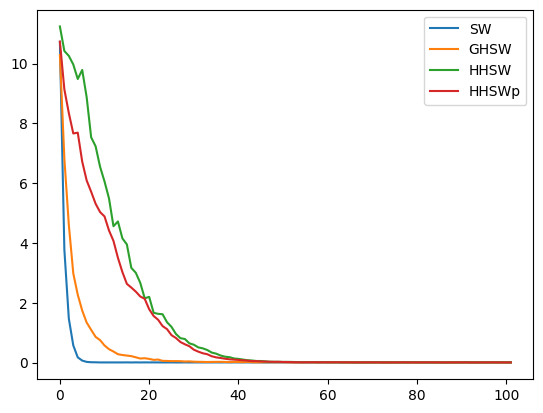

In [18]:
plt.plot(L_w_sw, label="SW")
plt.plot(L_w_ghsw, label="GHSW")
plt.plot(L_w_hhsw, label="HHSW")
plt.plot(L_w_hhsw_p, label="HHSWp")

plt.legend()
plt.show()

### Plot Particles

#### MWND + Center

In [19]:
n = 50

In [20]:
ps = np.ones(5)/5
# if args.target == "center":
mus_lorentz = torch.tensor([[0,0.5],[0.5,0],[0,-0.5],[-0.5,0], [0,0.1]], dtype=torch.float)
# elif args.target == "border":
#     mus_lorentz = torch.tensor([[0,0.9],[0.9,0],[0,-0.9],[-0.9,0], [0,0.1]], dtype=torch.float)

mus = manifold_poincare_horo.to_lorentz(mus_lorentz)
sigma = 0.01 * torch.tensor([[1,0],[0,1]], dtype=torch.float)

mu0 = torch.tensor([1,0,0], dtype=torch.float64, device=device)
Sigma0 = torch.eye(2, dtype=torch.float, device=device)

In [21]:
Z = np.random.multinomial(10000, ps)
X = []
for l in range(len(Z)):
    if Z[l]>0:
        samples = manifold_lorentz_horo.sample_wrapped_normal(int(Z[l]), mus[l], sigma).numpy()
        X += list(samples)

X_target = torch.tensor(X, device=device, dtype=torch.float64)

train_dl = torch.utils.data.DataLoader(X_target, batch_size=n, shuffle=True)
dataiter_lorentz = iter(cycle(train_dl))

X_target_poincare = manifold_lorentz_horo.to_poincare(X_target)
train_dl = torch.utils.data.DataLoader(X_target_poincare, batch_size=n, shuffle=True)
dataiter_poincare = iter(cycle(train_dl))

/tmp/ipykernel_36212/3012562159.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  X_target = torch.tensor(X, device=device, dtype=torch.float64)


In [22]:
n_epochs = 201
lr = 0.1
n_projs = 1000

x0 = manifold_lorentz_horo.sample_wrapped_normal(n, mu0, Sigma0)
x0_p = manifold_lorentz_horo.to_poincare(x0)

particles_swp = chswf(x0_p, n_epochs, dataiter_poincare, manifold_euclidean, tauk=lr, n_projs=n_projs)
particles_ghsw = chswf(x0, n_epochs, dataiter_lorentz, manifold_lorentz_geod, tauk=lr, n_projs=n_projs)
particles_hhsw = chswf(x0, n_epochs, dataiter_lorentz, manifold_lorentz_horo, tauk=lr, n_projs=n_projs)
particles_hhsw_p = chswf(x0_p, n_epochs, dataiter_poincare, manifold_poincare_horo, tauk=lr, n_projs=n_projs)

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

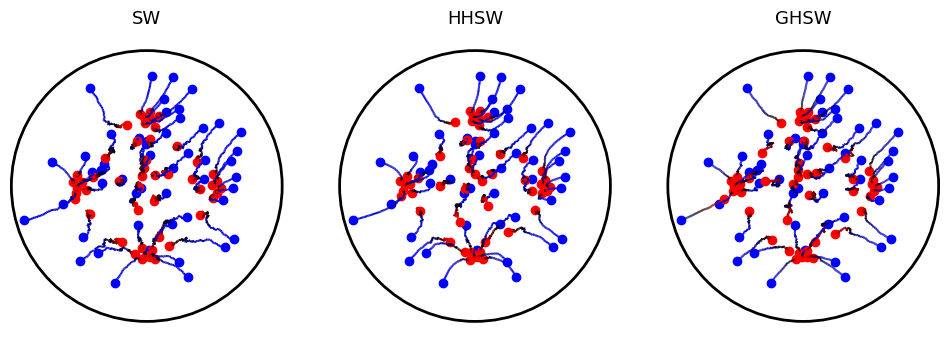

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(12,4)) #, gridspec_kw={"width_ratios":[1,2]})

plot_trajectory(np.array([particles_swp[k].numpy() for k in range(len(particles_swp))]), colorbar=False, ax=ax[0])
plot_trajectory(np.array([particles_hhsw_p[k].numpy() for k in range(len(particles_swp))]), ax=ax[1])
plot_trajectory(np.array([manifold_lorentz_horo.to_poincare(particles_ghsw[k]).numpy() for k in range(len(particles_swp))]), ax=ax[2])

ax[0].set_title("SW", fontsize=13)
ax[1].set_title("HHSW", fontsize=13)
ax[2].set_title("GHSW", fontsize=13)

# plt.savefig("./Evolution_trajectory_mixture_center.pdf", format="pdf", bbox_inches="tight")

plt.show()

#### MWND + Border

In [24]:
ps = np.ones(5)/5
# if args.target == "center":
# mus_lorentz = torch.tensor([[0,0.5],[0.5,0],[0,-0.5],[-0.5,0], [0,0.1]], dtype=torch.float)
# elif args.target == "border":
mus_lorentz = torch.tensor([[0,0.9],[0.9,0],[0,-0.9],[-0.9,0], [0,0.1]], dtype=torch.float)

mus = manifold_poincare_horo.to_lorentz(mus_lorentz)
sigma = 0.01 * torch.tensor([[1,0],[0,1]], dtype=torch.float)

mu0 = torch.tensor([1,0,0], dtype=torch.float64, device=device)
Sigma0 = torch.eye(2, dtype=torch.float, device=device)

In [25]:
Z = np.random.multinomial(10000, ps)
X = []
for l in range(len(Z)):
    if Z[l]>0:
        samples = manifold_lorentz_horo.sample_wrapped_normal(int(Z[l]), mus[l], sigma).numpy()
        X += list(samples)

X_target = torch.tensor(X, device=device, dtype=torch.float64)

train_dl = torch.utils.data.DataLoader(X_target, batch_size=n, shuffle=True)
dataiter_lorentz = iter(cycle(train_dl))

X_target_poincare = manifold_lorentz_horo.to_poincare(X_target)
train_dl = torch.utils.data.DataLoader(X_target_poincare, batch_size=n, shuffle=True)
dataiter_poincare = iter(cycle(train_dl))

In [26]:
n_epochs = 301
lr = 0.5
n_projs = 1000

x0 = manifold_lorentz_horo.sample_wrapped_normal(n, mu0, Sigma0)
x0_p = manifold_lorentz_horo.to_poincare(x0)

particles_swp = chswf(x0_p, n_epochs, dataiter_poincare, manifold_euclidean, tauk=lr, n_projs=n_projs)
particles_ghsw = chswf(x0, n_epochs, dataiter_lorentz, manifold_lorentz_geod, tauk=lr, n_projs=n_projs)
particles_hhsw = chswf(x0, n_epochs, dataiter_lorentz, manifold_lorentz_horo, tauk=lr, n_projs=n_projs)
particles_hhsw_p = chswf(x0_p, n_epochs, dataiter_poincare, manifold_poincare_horo, tauk=lr, n_projs=n_projs)

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

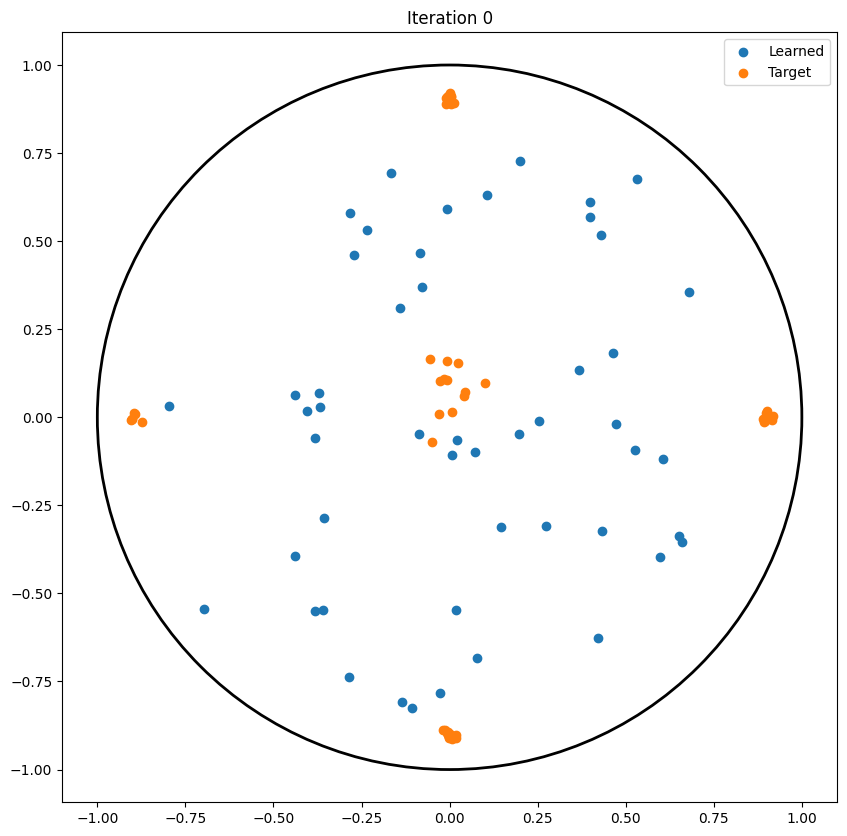

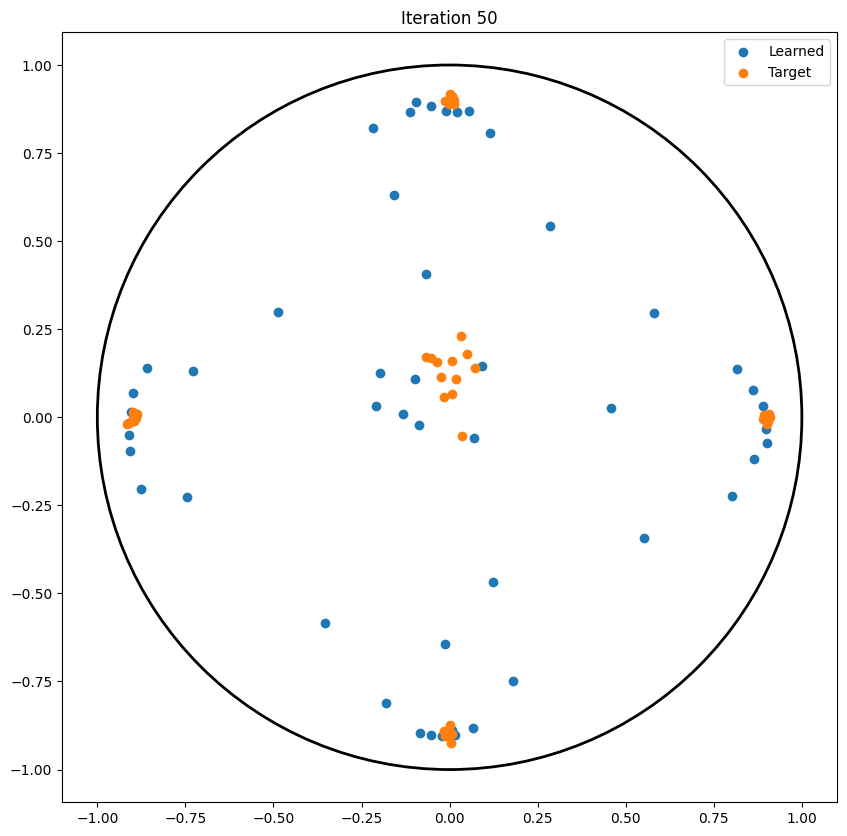

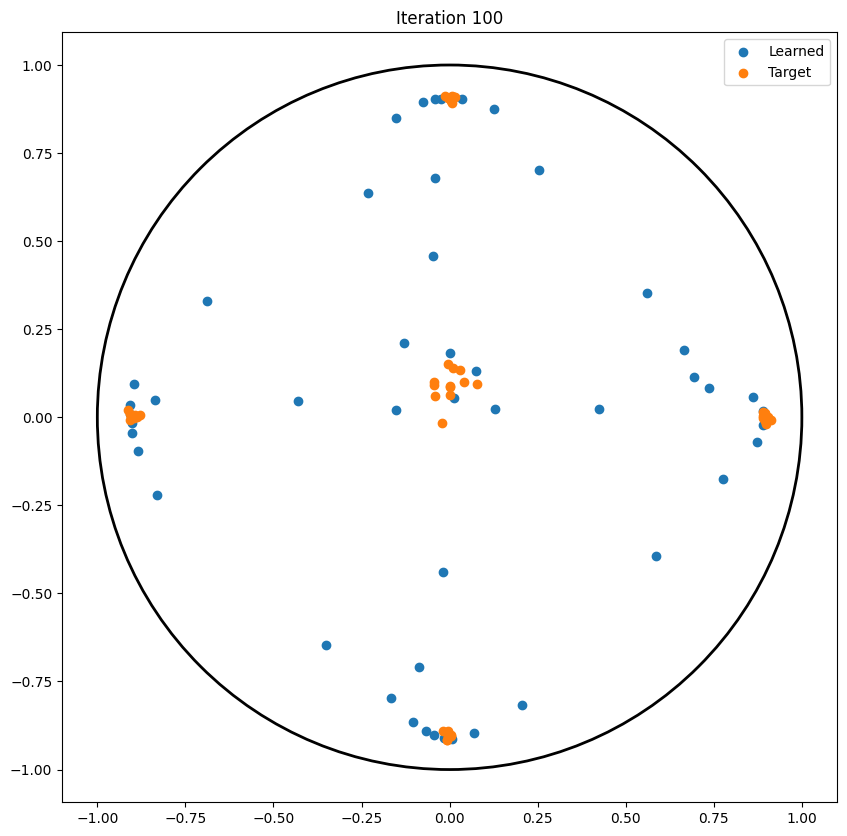

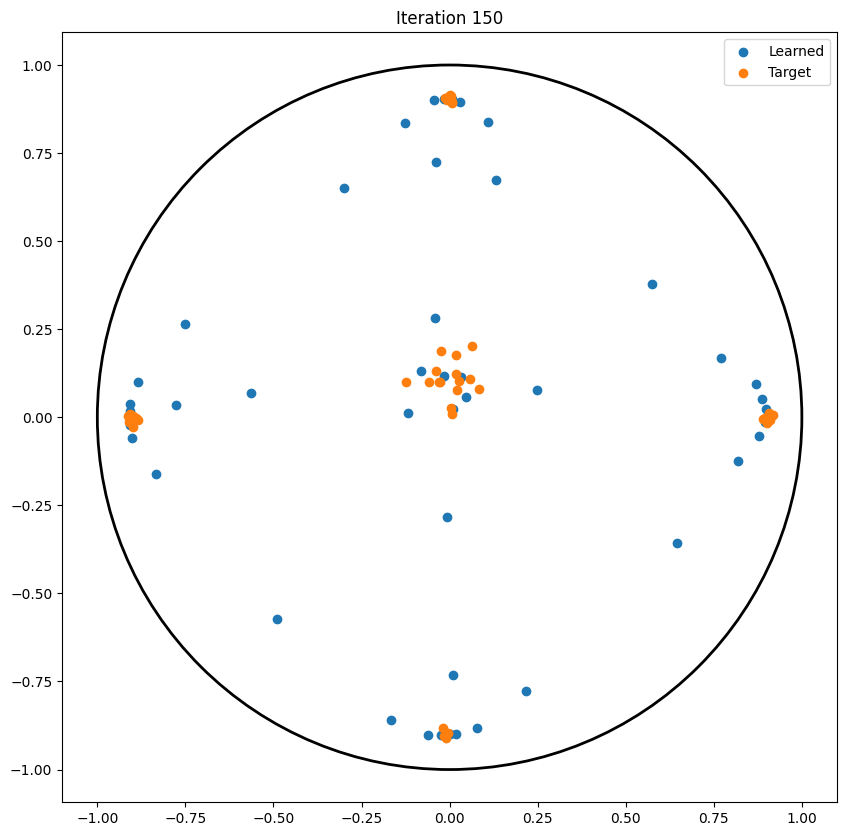

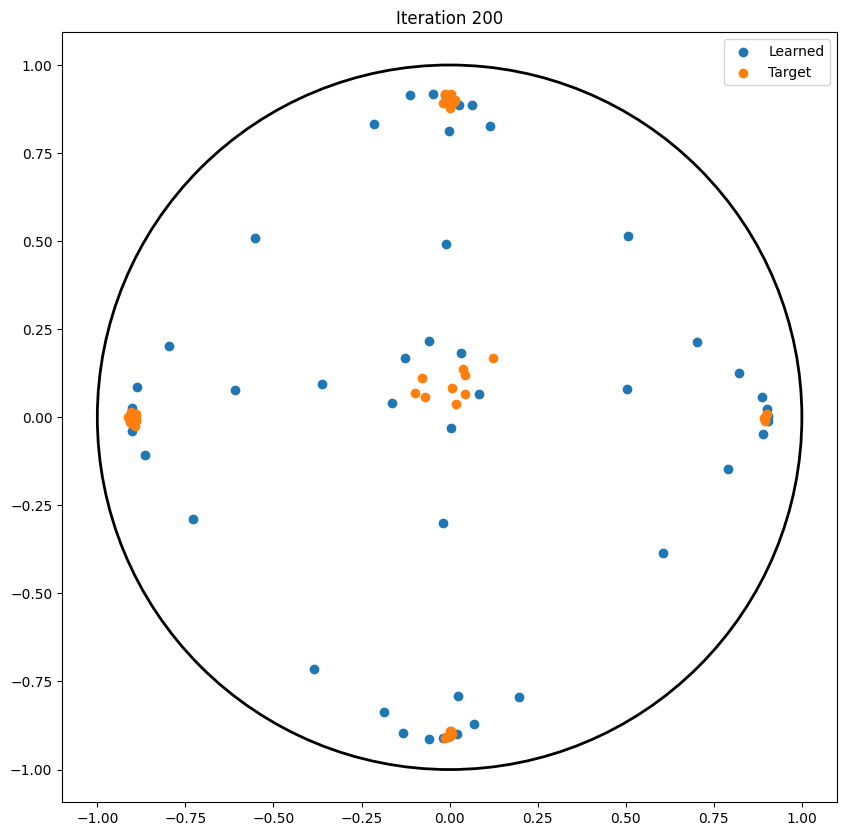

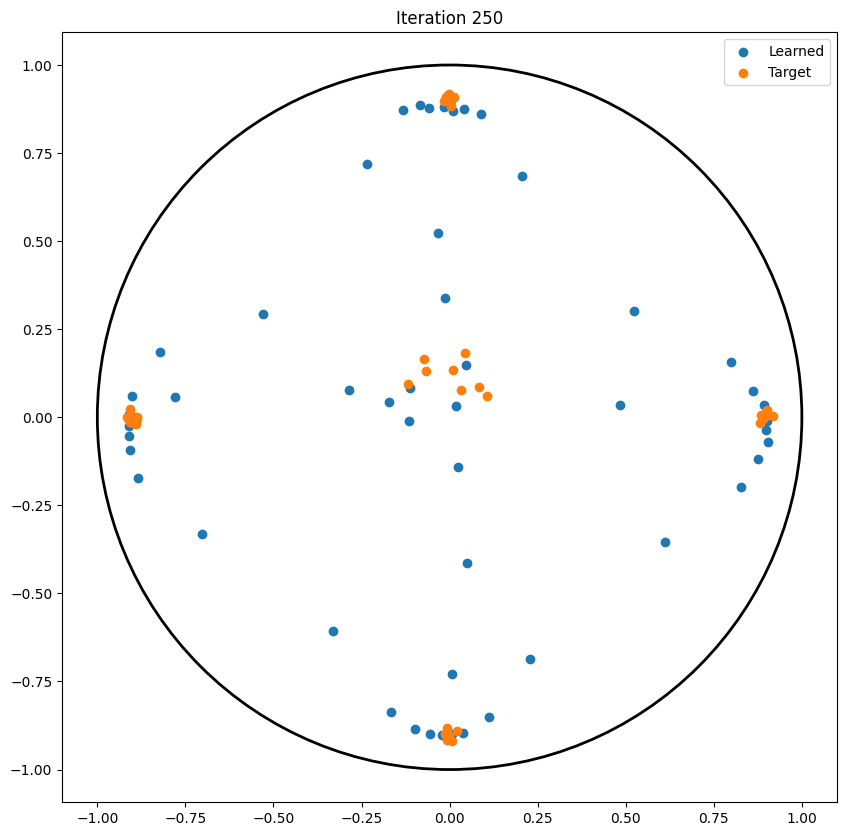

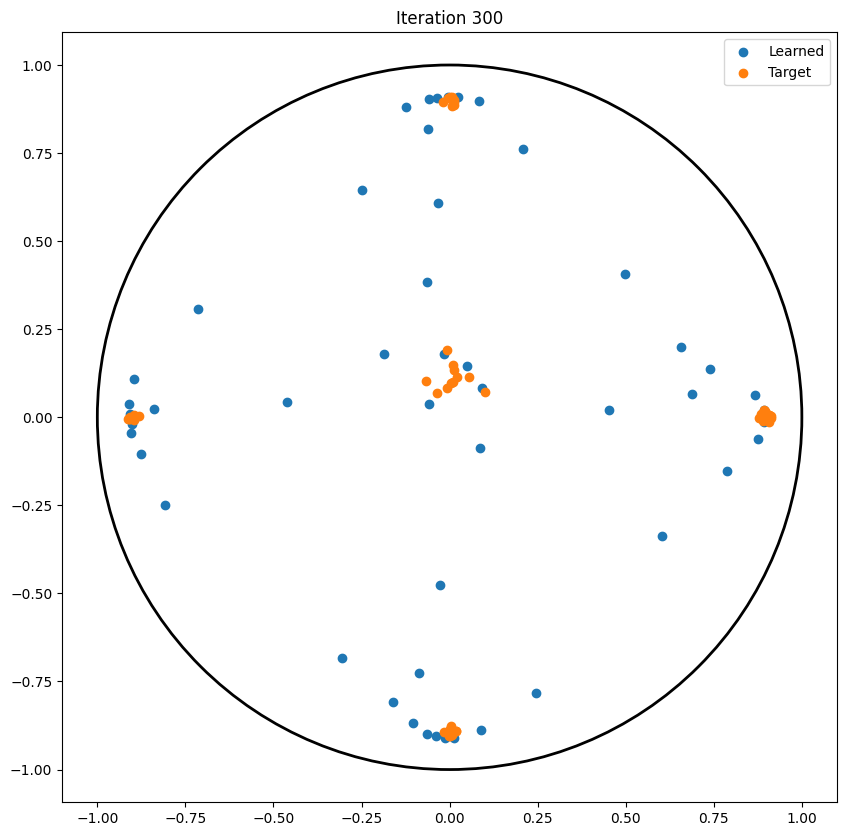

In [27]:
for k in range(0, 301, 50):
    target = next(dataiter_poincare).detach()

    utils_plot_poincare(particles_swp[k], target, k)

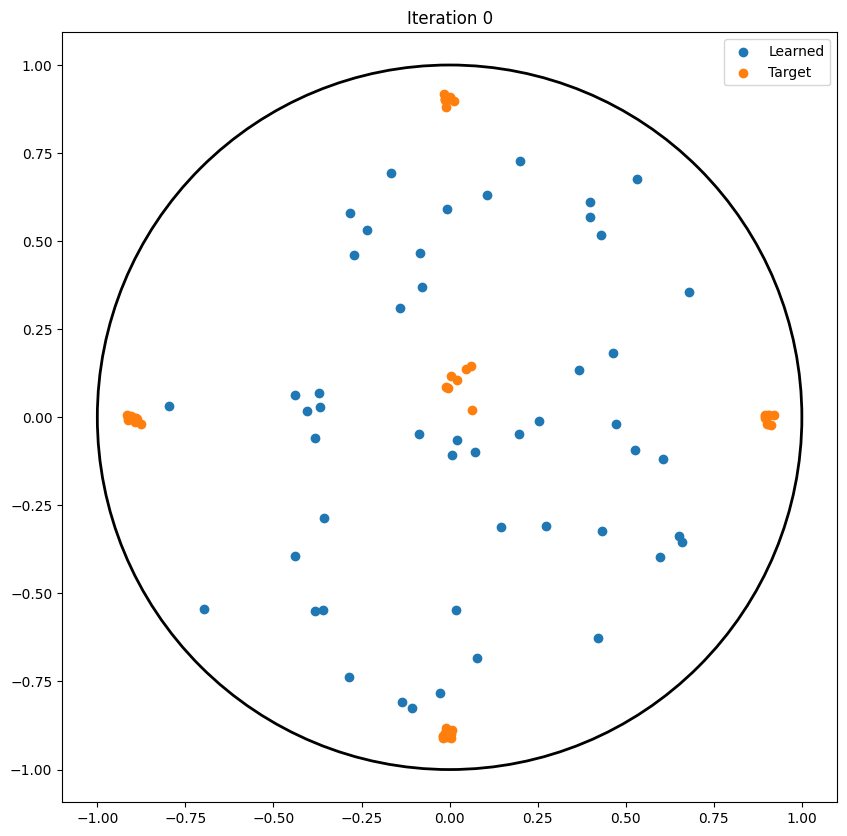

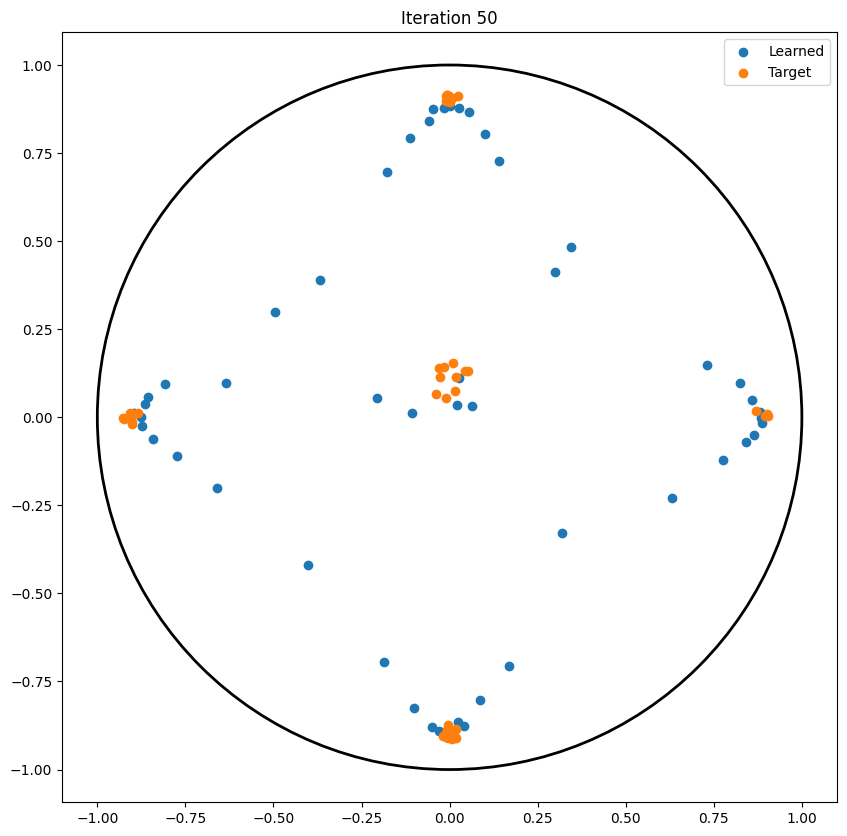

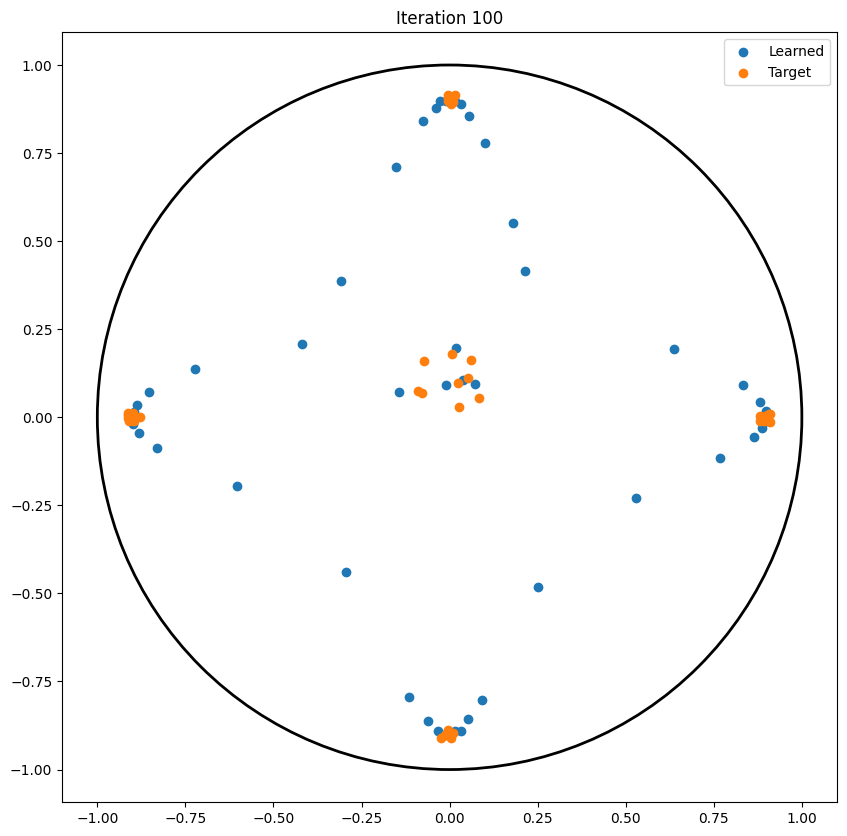

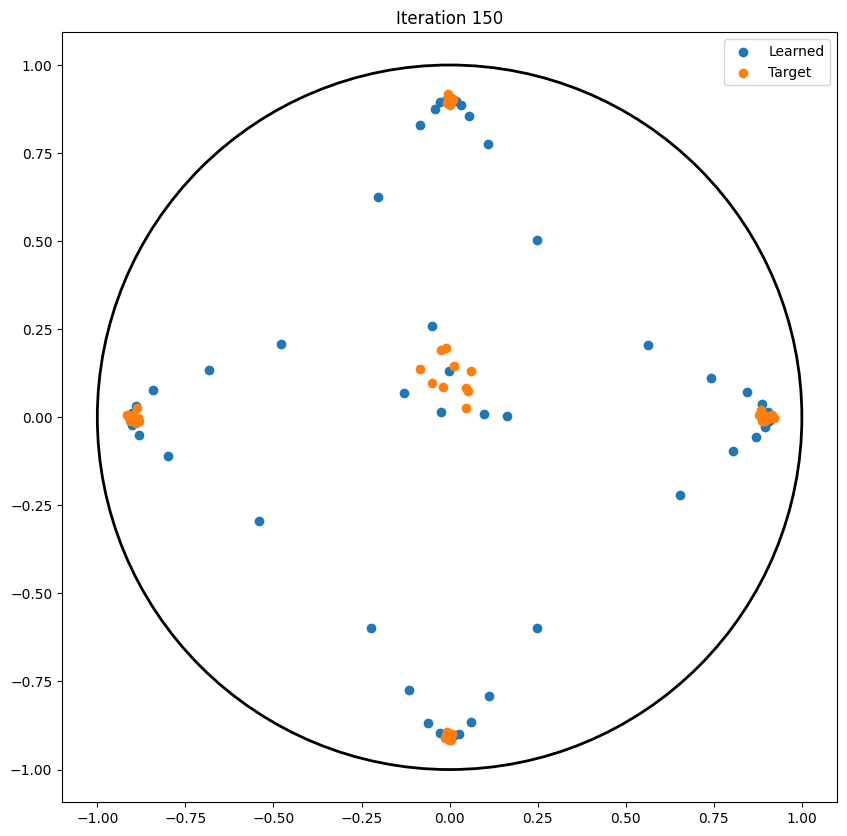

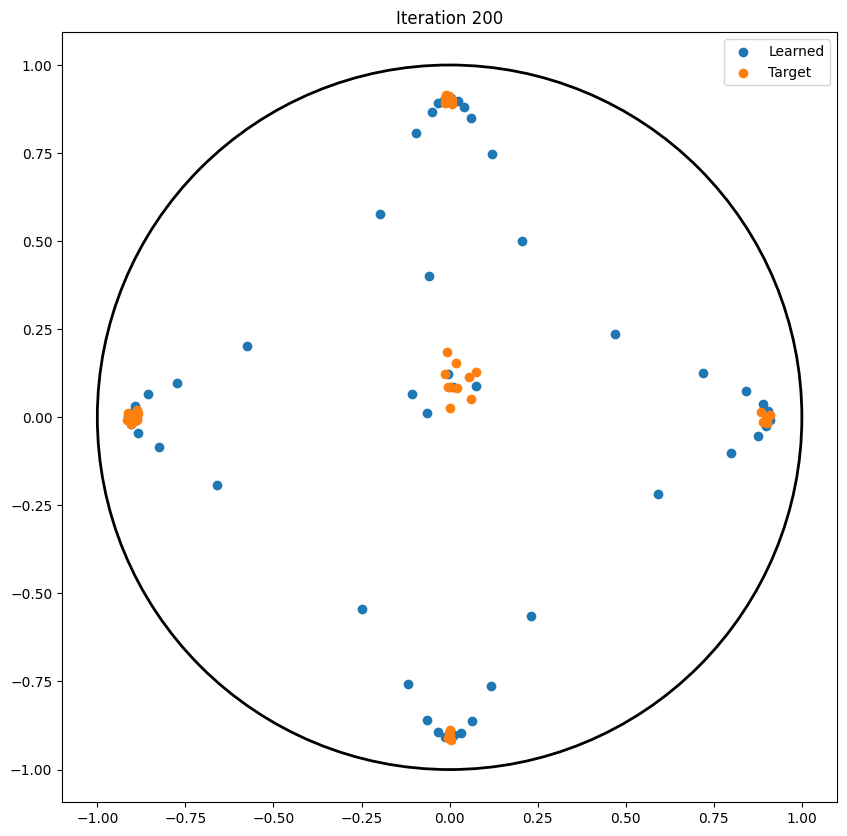

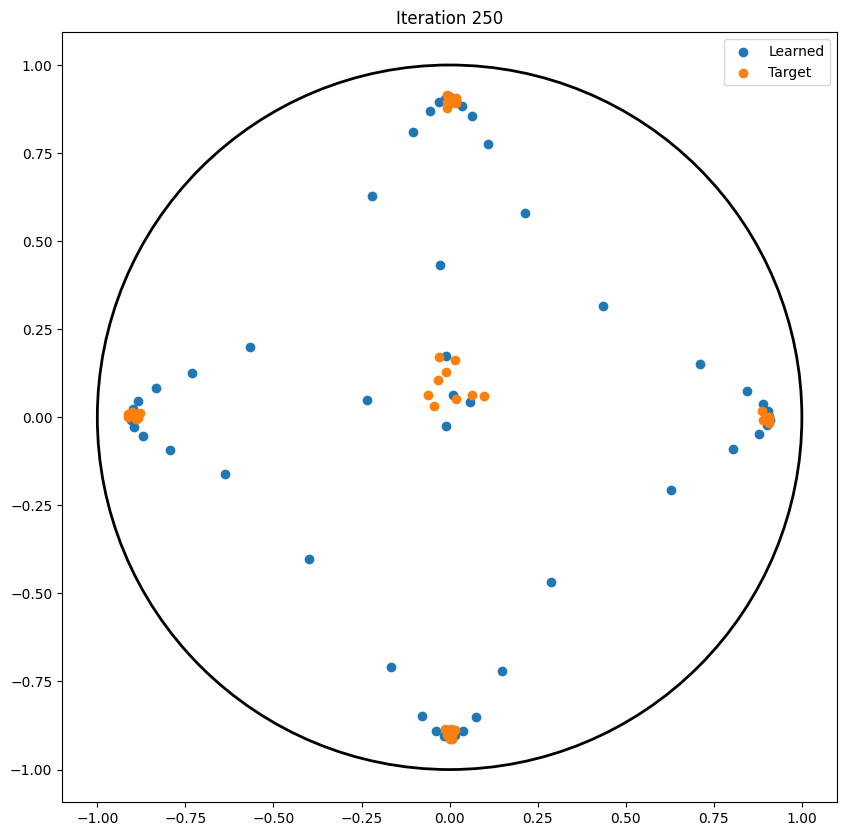

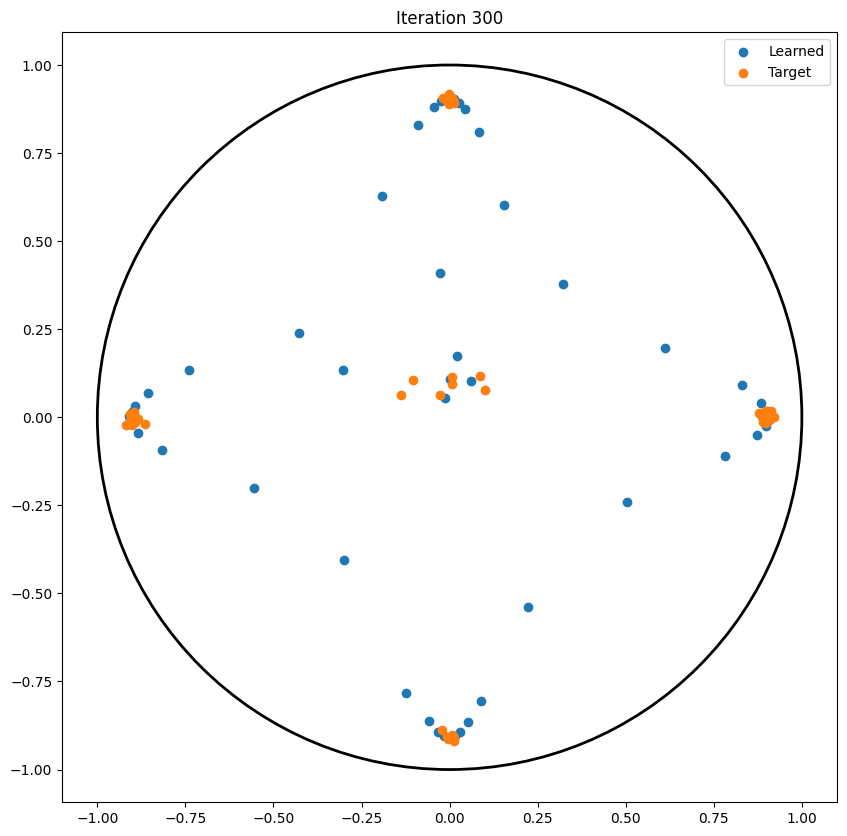

In [28]:
for k in range(0, 301, 50):
    target = next(dataiter_poincare).detach()

    utils_plot_poincare(manifold_lorentz_horo.to_poincare(particles_ghsw[k]), target, k)

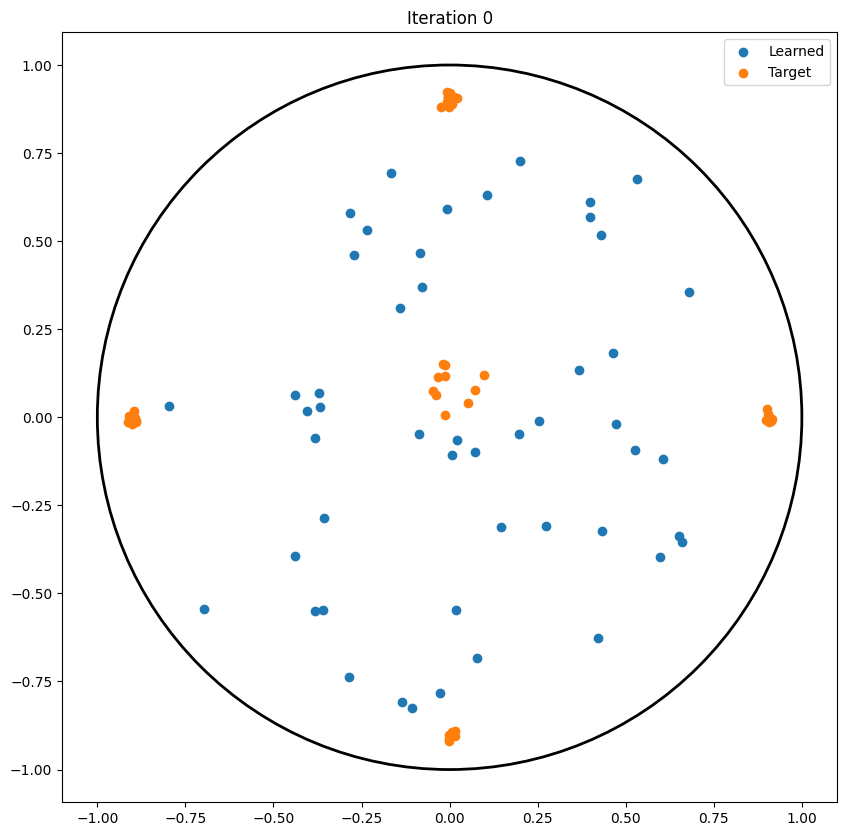

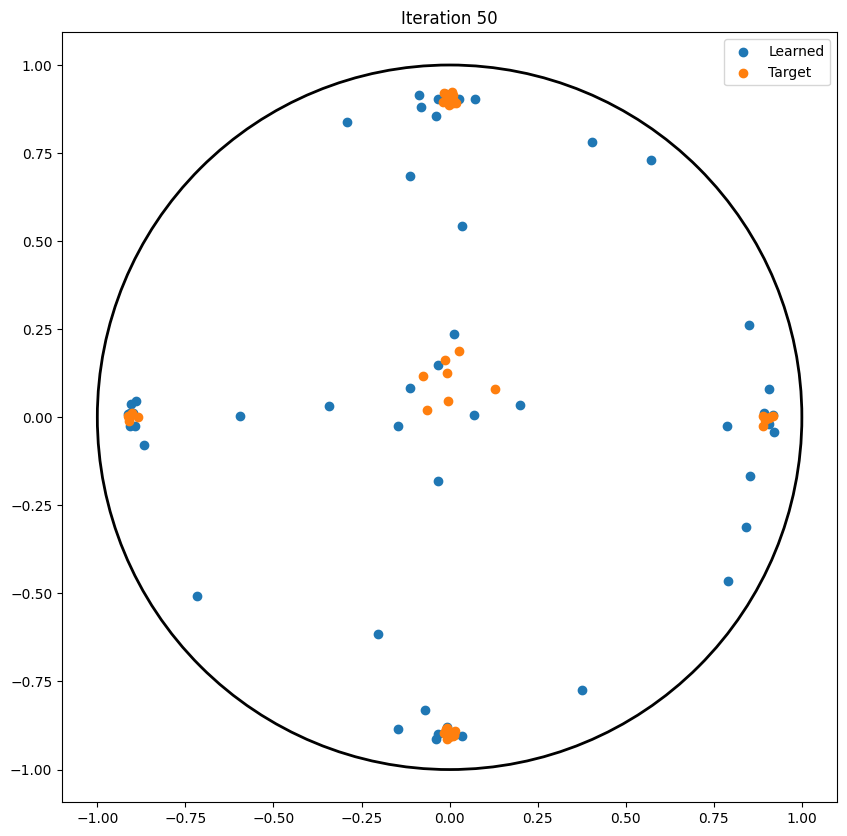

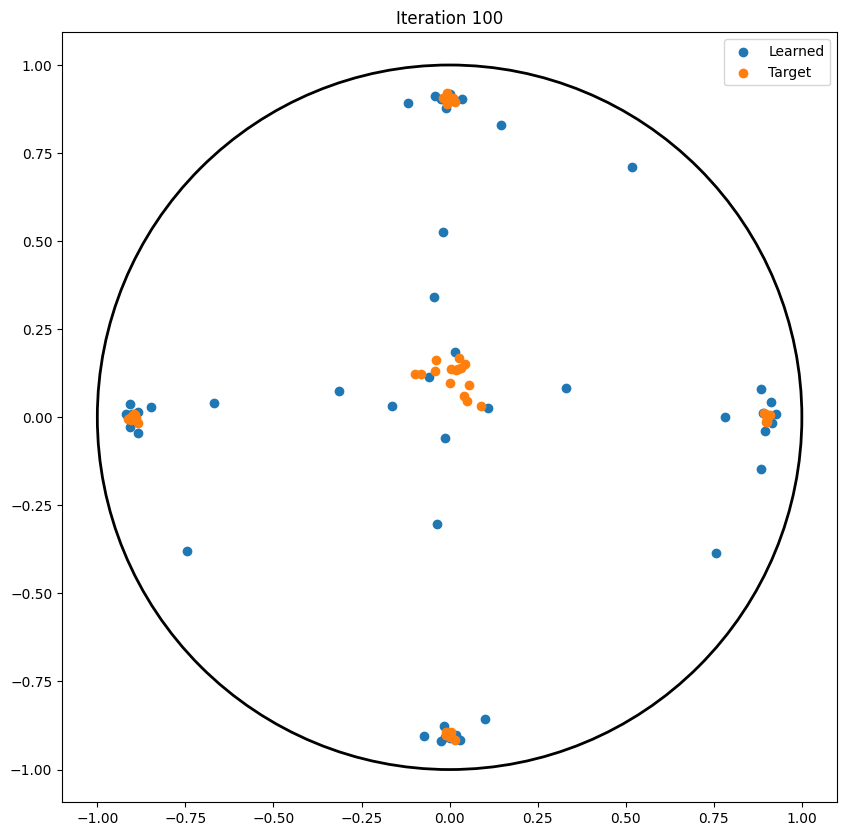

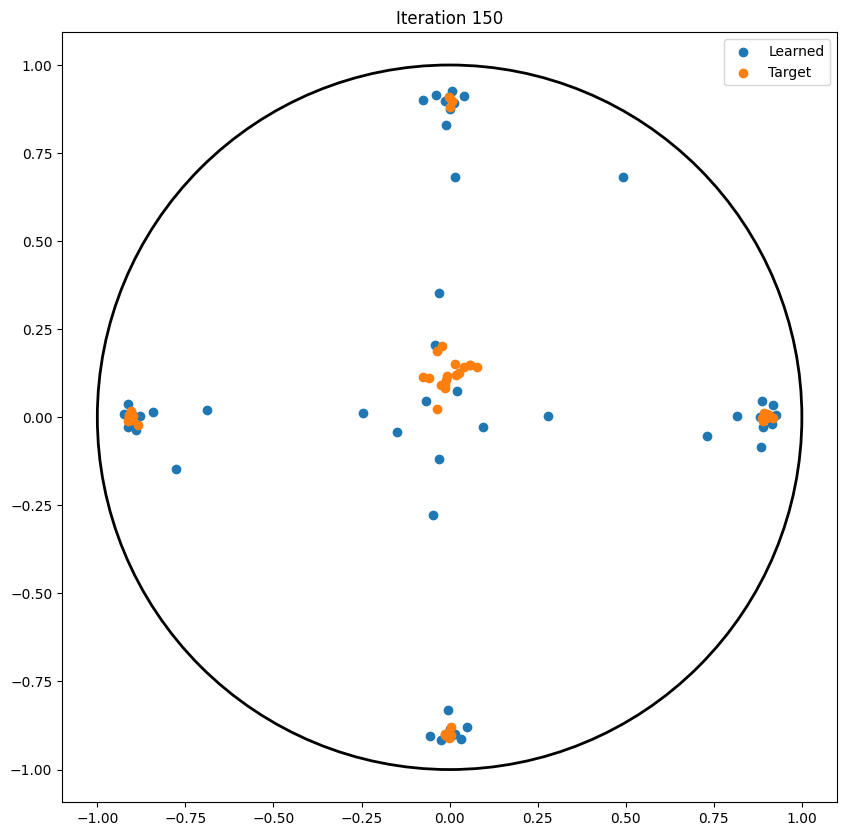

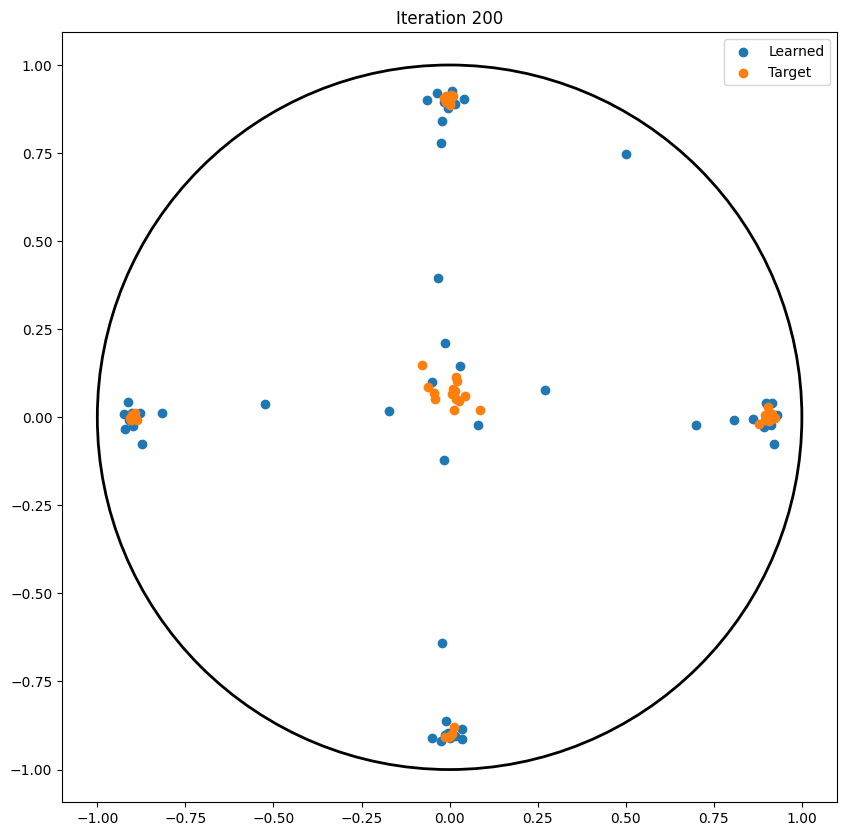

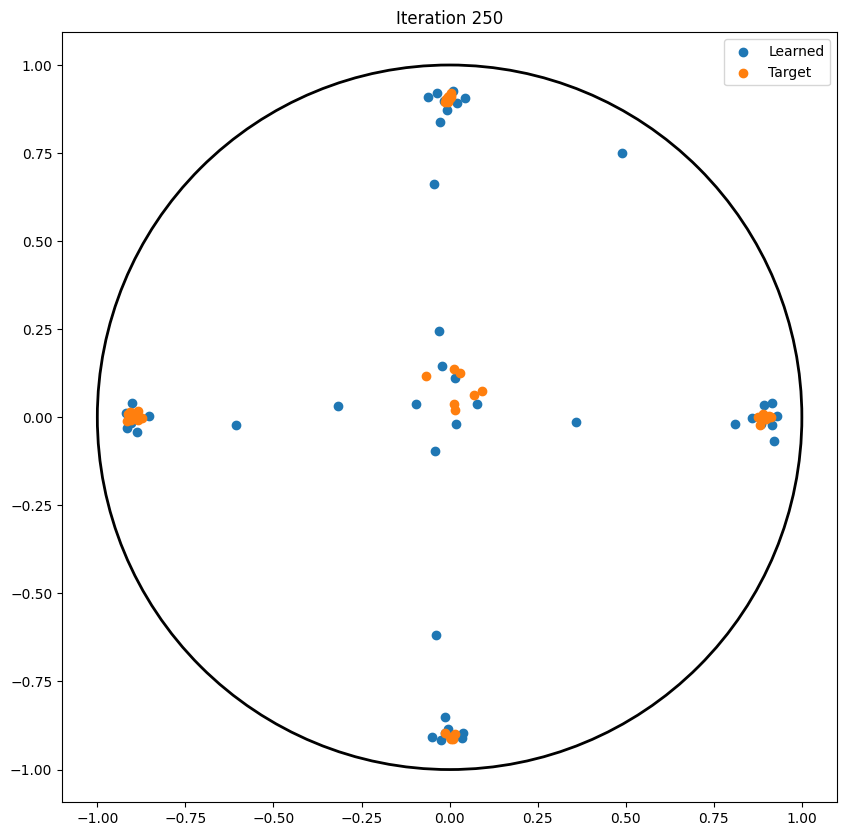

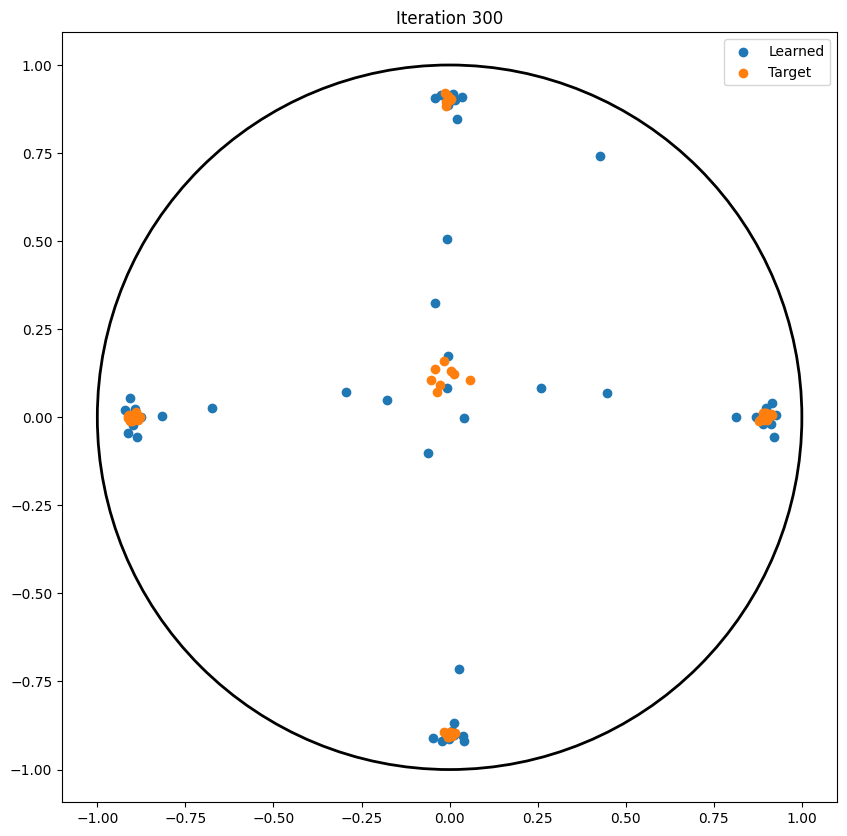

In [29]:
for k in range(0, 301, 50):
    target = next(dataiter_poincare).detach()

    utils_plot_poincare(particles_hhsw_p[k], target, k)

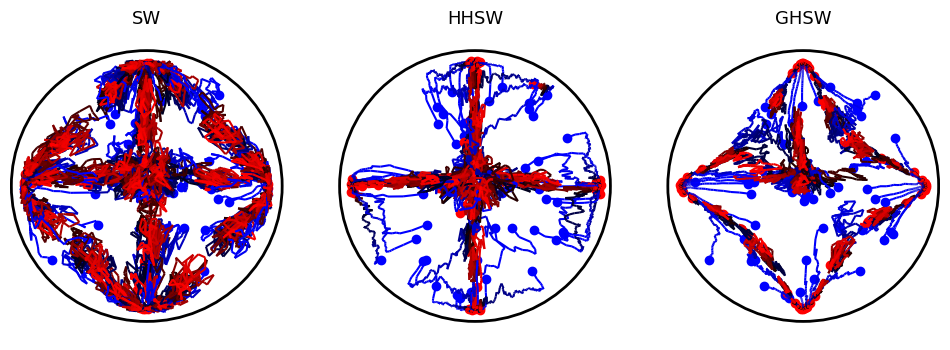

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(12,4)) #, gridspec_kw={"width_ratios":[1,2]})

plot_trajectory(np.array([particles_swp[k].numpy() for k in range(len(particles_swp))]), colorbar=False, ax=ax[0])
plot_trajectory(np.array([particles_hhsw_p[k].numpy() for k in range(len(particles_swp))]), ax=ax[1])
plot_trajectory(np.array([manifold_lorentz_horo.to_poincare(particles_ghsw[k]).numpy() for k in range(len(particles_swp))]), ax=ax[2])

ax[0].set_title("SW", fontsize=13)
ax[1].set_title("HHSW", fontsize=13)
ax[2].set_title("GHSW", fontsize=13)

# plt.savefig("./Evolution_trajectory_mixture_border.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [31]:
n = 50

In [32]:
Z = np.random.multinomial(10000, ps)
X = []
for l in range(len(Z)):
    if Z[l]>0:
        samples = manifold_lorentz_horo.sample_wrapped_normal(int(Z[l]), mus[l], sigma).numpy()
        X += list(samples)

X_target = torch.tensor(X, device=device, dtype=torch.float64)

train_dl = torch.utils.data.DataLoader(X_target, batch_size=n, shuffle=True)
dataiter_lorentz = iter(cycle(train_dl))

X_target_poincare = manifold_lorentz_horo.to_poincare(X_target)
train_dl = torch.utils.data.DataLoader(X_target_poincare, batch_size=n, shuffle=True)
dataiter_poincare = iter(cycle(train_dl))

In [33]:
n_epochs = 301
lr = 0.5
n_projs = 1000

x0 = manifold_lorentz_horo.sample_wrapped_normal(n, mu0, Sigma0)
x0_p = manifold_lorentz_horo.to_poincare(x0)

particles_swp = chswf(x0_p, n_epochs, dataiter_poincare, manifold_euclidean, tauk=lr, n_projs=n_projs)
particles_ghsw = chswf(x0, n_epochs, dataiter_lorentz, manifold_lorentz_geod, tauk=lr, n_projs=n_projs)
particles_hhsw = chswf(x0, n_epochs, dataiter_lorentz, manifold_lorentz_horo, tauk=lr, n_projs=n_projs)
particles_hhsw_p = chswf(x0_p, n_epochs, dataiter_poincare, manifold_poincare_horo, tauk=lr, n_projs=n_projs)

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

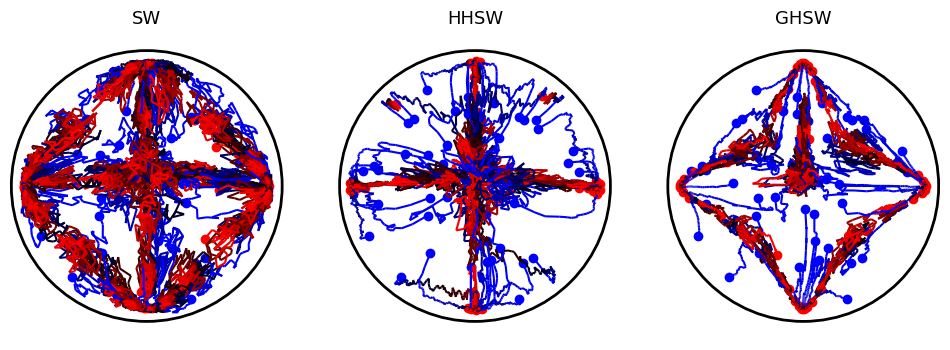

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(12,4)) #, gridspec_kw={"width_ratios":[1,2]})

plot_trajectory(np.array([particles_swp[k].numpy() for k in range(len(particles_swp))]), colorbar=False, ax=ax[0])
plot_trajectory(np.array([particles_hhsw_p[k].numpy() for k in range(len(particles_swp))]), ax=ax[1])
plot_trajectory(np.array([manifold_lorentz_horo.to_poincare(particles_ghsw[k]).numpy() for k in range(len(particles_swp))]), ax=ax[2])

ax[0].set_title("SW", fontsize=13)
ax[1].set_title("HHSW", fontsize=13)
ax[2].set_title("GHSW", fontsize=13)

# plt.savefig("./Evolution_trajectory_mixture_border.pdf", format="pdf", bbox_inches="tight")

plt.show()

#### WND + Center

In [35]:
mu = torch.tensor([1.5, np.sqrt(1.5**2-1), 0], dtype=torch.float64, device=device)
Sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)


mu0 = torch.tensor([1,0,0], dtype=torch.float64, device=device)
Sigma0 = torch.eye(2, dtype=torch.float, device=device)

In [37]:
X_target = manifold_lorentz_horo.sample_wrapped_normal(10000, mu, Sigma)

train_dl = torch.utils.data.DataLoader(X_target, batch_size=500, shuffle=True)
dataiter_lorentz = iter(cycle(train_dl))

X_target_poincare = manifold_lorentz_horo.to_poincare(X_target)
train_dl = torch.utils.data.DataLoader(X_target_poincare, batch_size=500, shuffle=True)
dataiter_poincare = iter(cycle(train_dl))

In [38]:
n_epochs = 201
lr = 0.1
n_projs = 100

x0 = manifold_lorentz_horo.sample_wrapped_normal(n, mu0, Sigma0)
x0_p = manifold_lorentz_horo.to_poincare(x0)

particles_swp = chswf(x0_p, n_epochs, dataiter_poincare, manifold_euclidean, tauk=lr, n_projs=n_projs)
particles_ghsw = chswf(x0, n_epochs, dataiter_lorentz, manifold_lorentz_geod, tauk=lr, n_projs=n_projs)
particles_hhsw = chswf(x0, n_epochs, dataiter_lorentz, manifold_lorentz_horo, tauk=lr, n_projs=n_projs)
particles_hhsw_p = chswf(x0_p, n_epochs, dataiter_poincare, manifold_poincare_horo, tauk=lr, n_projs=n_projs)

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

  0%|          | 0/201 [00:00<?, ?it/s]

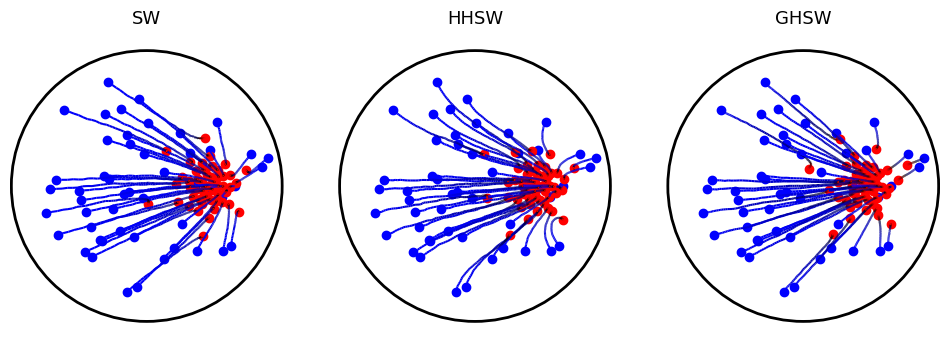

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(12,4)) #, gridspec_kw={"width_ratios":[1,2]})

plot_trajectory(np.array([particles_swp[k].numpy() for k in range(len(particles_swp))]), colorbar=False, ax=ax[0])
plot_trajectory(np.array([particles_hhsw_p[k].numpy() for k in range(len(particles_swp))]), ax=ax[1])
plot_trajectory(np.array([manifold_lorentz_horo.to_poincare(particles_ghsw[k]).numpy() for k in range(len(particles_swp))]), ax=ax[2])

ax[0].set_title("SW", fontsize=13)
ax[1].set_title("HHSW", fontsize=13)
ax[2].set_title("GHSW", fontsize=13)

# plt.savefig("./Evolution_trajectory_wnd_center.pdf", format="pdf", bbox_inches="tight")

plt.show()

#### WND + Border

In [40]:
mu = torch.tensor([8, np.sqrt(63), 0], dtype=torch.float64, device=device)
Sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)


mu0 = torch.tensor([1,0,0], dtype=torch.float64, device=device)
Sigma0 = torch.eye(2, dtype=torch.float, device=device)

In [41]:
X_target = manifold_lorentz_horo.sample_wrapped_normal(10000, mu, Sigma)

train_dl = torch.utils.data.DataLoader(X_target, batch_size=500, shuffle=True)
dataiter_lorentz = iter(cycle(train_dl))

X_target_poincare = manifold_lorentz_horo.to_poincare(X_target)
train_dl = torch.utils.data.DataLoader(X_target_poincare, batch_size=500, shuffle=True)
dataiter_poincare = iter(cycle(train_dl))

In [42]:
n_epochs = 301
lr = 0.5
n_projs = 100

x0 = manifold_lorentz_horo.sample_wrapped_normal(n, mu0, Sigma0)
x0_p = manifold_lorentz_horo.to_poincare(x0)

particles_swp = chswf(x0_p, n_epochs, dataiter_poincare, manifold_euclidean, tauk=lr, n_projs=n_projs)
particles_ghsw = chswf(x0, n_epochs, dataiter_lorentz, manifold_lorentz_geod, tauk=lr, n_projs=n_projs)
particles_hhsw = chswf(x0, n_epochs, dataiter_lorentz, manifold_lorentz_horo, tauk=lr, n_projs=n_projs)
particles_hhsw_p = chswf(x0_p, n_epochs, dataiter_poincare, manifold_poincare_horo, tauk=lr, n_projs=n_projs)

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

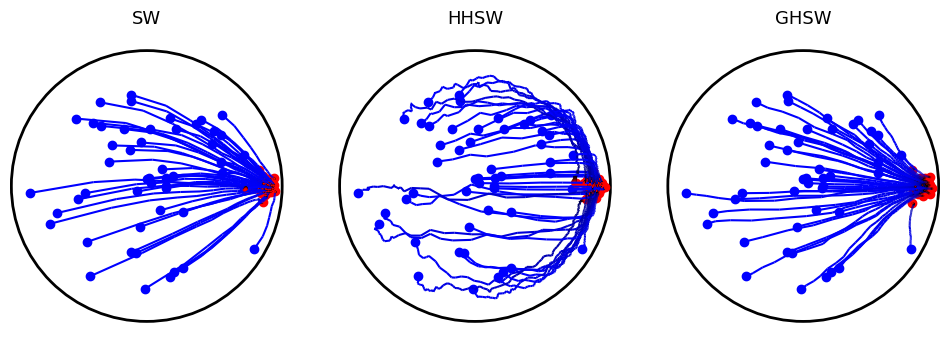

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(12,4)) #, gridspec_kw={"width_ratios":[1,2]})

plot_trajectory(np.array([particles_swp[k].numpy() for k in range(len(particles_swp))]), colorbar=False, ax=ax[0])
plot_trajectory(np.array([particles_hhsw_p[k].numpy() for k in range(len(particles_swp))]), ax=ax[1])
plot_trajectory(np.array([manifold_lorentz_horo.to_poincare(particles_ghsw[k]).numpy() for k in range(len(particles_swp))]), ax=ax[2])

ax[0].set_title("SW", fontsize=13)
ax[1].set_title("HHSW", fontsize=13)
ax[2].set_title("GHSW", fontsize=13)

# plt.savefig("./Evolution_trajectory_wnd_border.pdf", format="pdf", bbox_inches="tight")

plt.show()